In [25]:
import pandas as pd
import tensorflow as tf
import math
import cv2
import numpy as np
from collections import Counter
import os
import matplotlib.pyplot as plt



def crop1(img):
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, thresh = cv2.threshold(gray.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    close = cv2.morphologyEx(gray.astype(np.uint8), cv2.MORPH_CLOSE, close_kernel, iterations=1)

    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    dilate = cv2.dilate(close, dilate_kernel, iterations=1)

    cnts,_ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     mask=np.zeros_like(gray)
    areas =list()
    for c in cnts:
        area = cv2.contourArea(c)
        areas.append(area)

    c_=cnts[np.argmax(areas)]
    x,y,w,h = cv2.boundingRect(c_)
    return img[y:y+h,x:x+w]



def remove_text(img):
    def decode(scores, geometry, scoreThresh):
        detections = []
        confidences = []

        ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
        assert len(scores.shape) == 4, "Incorrect dimensions of scores"
        assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
        assert scores.shape[0] == 1, "Invalid dimensions of scores"
        assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
        assert scores.shape[1] == 1, "Invalid dimensions of scores"
        assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
        assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
        assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
        height = scores.shape[2]
        width = scores.shape[3]
        for y in range(0, height):

            # Extract data from scores
            scoresData = scores[0][0][y]
            x0_data = geometry[0][0][y]
            x1_data = geometry[0][1][y]
            x2_data = geometry[0][2][y]
            x3_data = geometry[0][3][y]
            anglesData = geometry[0][4][y]
            for x in range(0, width):
                score = scoresData[x]

                # If score is lower than threshold score, move to next x
                if(score < scoreThresh):
                    continue

                # Calculate offset
                offsetX = x * 4.0
                offsetY = y * 4.0
                angle = anglesData[x]

                # Calculate cos and sin of angle
                cosA = math.cos(angle)
                sinA = math.sin(angle)
                h = x0_data[x] + x2_data[x]
                w = x1_data[x] + x3_data[x]

                # Calculate offset
                offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

                # Find points for rectangle
                p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
                p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
                center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
                detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
                confidences.append(float(score))

        # Return detections and confidences
        return [detections, confidences]
   
    net = cv2.dnn.readNet('/home/g007markphillip/model_artifacts2/models/weights/frozen_east_text_detection.pb')
    blob = cv2.dnn.blobFromImage(img, 1.0, (320,320), (123.68, 116.78, 103.94), False, False)
    outputLayers = []
    outputLayers.append("feature_fusion/Conv_7/Sigmoid")
    outputLayers.append("feature_fusion/concat_3")
    net.setInput(blob)
    output = net.forward(outputLayers)
    scores = output[0]
    geometry = output[1]
    [boxes, confidences] = decode(scores, geometry, 0.99)
    indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, 0.5,0.5)
    collect=[]
    if len(boxes)!=0:
        for i in indices:
            # get 4 corners of the rotated rect
            vertices = cv2.boxPoints(boxes[i])
            # scale the bounding box coordinates based on the respective ratios
            for j in range(4):
                vertices[j][0] *=img.shape[1]/320
                vertices[j][1] *= img.shape[0]/320
            for j in range(4):
                p1 = (vertices[j][0], vertices[j][1])
                p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
                collect.append(p1)   
        collect=np.array(collect)
        mse=lambda x:x[0]**2+x[1]**2
        mse=np.apply_along_axis(mse,1,collect)
        sqrt = np.sqrt(mse)   
        min_=collect[np.argmin(sqrt)].astype('int').tolist()
        max_=collect[np.argmax(sqrt)].astype('int').tolist()
        
        if True in np.where(np.array(min_)<0,True,False):
            min_[np.where(np.array(min_)<0)[0].tolist()[0]]=0
        min_[1],max_[1],min_[0],max_[0] = min_[1]-3,max_[1]+3,0,max_[0]+15
    else:
        min_,max_= [0,0],[0,0]
    
    mask=np.zeros((img.shape[:-1]))
    mask[min_[1]:max_[1],min_[0]:max_[0]]=255
    img[min_[1]:max_[1],min_[0]:max_[0]]=0
    img=cv2.inpaint(img.astype('uint8'),mask.astype('uint8'),40,cv2.INPAINT_TELEA)
    return img

def remove_circles_(img):
    #### get circles in a straight line 
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    thresholded = np.logical_and(*[lab[..., i] > t for i, t in enumerate([210, 0, 0])])
    thresholded=thresholded.astype('uint8')*255
    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    close = cv2.morphologyEx(thresholded.astype(np.uint8), cv2.MORPH_CLOSE, close_kernel, iterations=1)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    dilate = cv2.dilate(close, dilate_kernel, iterations=1)   
    mask=np.zeros((img.shape[:-1]))
    cnts,_ = cv2.findContours(dilate.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    try:
        listx=[]
        listy=[]
        listw=[]
        listh=[]
        for cnt in cnts:
            x,y,w,h = cv2.boundingRect(cnt)
            listx.append(x)
            listy.append(y)
            listw.append(w)
            listh.append(h)

        roundedx=np.floor(np.array(listx)/10)*10
        counts=Counter(roundedx)    
        indxs=np.where(roundedx==counts.most_common()[0][0])[0]
        listx=np.array(listx)[indxs]
        listy=np.array(listy)[indxs]
        listw=np.array(listw)[indxs]
        listh=np.array(listh)[indxs]

        if len(listx)>8: #### the circles are the majority
            for x_,y_,w_,h_ in zip(listx,listy,listw,listh):
                mask[y_:y_+h_,x_:x_+w_]=255
            img=cv2.inpaint(img.astype('uint8'),mask.astype('uint8'),4,cv2.INPAINT_TELEA)  
    except:
        img=img
    return img


def remove_P(img):
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, thresh = cv2.threshold(gray.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    close = cv2.morphologyEx(gray.astype(np.uint8), cv2.MORPH_CLOSE, close_kernel, iterations=1)

    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(close, dilate_kernel, iterations=1)

    cnts,_ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas =list()
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        if area>800 and area<900:
            x,y,w,h = cv2.boundingRect(c)
            img[y:y+h,x:x+w]=0
    return img




def preprocess_img(img):
    
    img = crop1(img)
    img =  remove_text(img)
    img = remove_circles_(img)
    img=remove_P(img)
    return img




# if __name__ =='__main__':


# #     data = pd.read_csv('../inputs/testset.csv')
# #     data=data.rename(columns={'Normal':'alines','>3 B-lines':'blines','Consolidation':'consolidation','Effusion':'effusion'})
# #     data.image=data.image.apply(lambda x: '../dataset/extracted/'+x)
# #     data.image=data.image.apply(lambda x:x.replace(' ','_'))



#     image_data = os.listdir('../dataset/extracted')
#     i=0
#     while i<(len(image_data)):
# #         try:
#         print(i)
#         k = cv2.imread('../dataset/extracted/'+image_data[i])
#         k = cv2.cvtColor(k,cv2.COLOR_BGR2RGB)
#         k = preprocess_img(k)
#         name="../dataset/denoised_data/"+image_data[i]
#         cv2.imwrite(name,k)
#         i+=1
# #         except:
# #             print(i)
# #         i+=1


In [51]:
import os
os.path.dirname(os.getcwd())

'/home/g007markphillip/model_artifacts2'

In [74]:
k = cv2.imread(os.path.dirname(os.getcwd())+'/data/processed/images/25_04_2022_13_03_08_4.25.2022.13.3.9_26-12_2_52.tif')
# k = cv2.cvtColor(k,cv2.COLOR_BGR2RGB)
k = crop1(k)
k = remove_text(k)
k = remove_circles_(k)
k = remove_P(k)

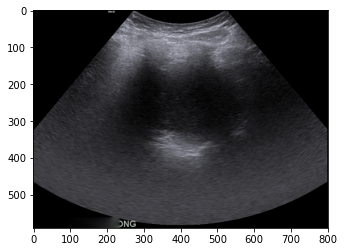

In [75]:
plt.imshow(k)

In [31]:
#Install keras_ocr
# !pip install keras-ocr

# import libraries
# import keras_ocr
import cv2

# This  removes the text that may exist on the image
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def inpaint_text(img, pipeline):    
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 2, cv2.INPAINT_TELEA)
                 
    return(img)

## Function call
# pipeline = keras_ocr.pipeline.Pipeline()
# img = cv2.imread('img_path')

# image = inpaint_text(img,pipeline)

